In [ ]:
# Standard libraries
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Add current directory to path
sys.path.append(os.getcwd())

# Force reload of protest_library modules to ensure latest version
import importlib

if 'protest_library.models' in sys.modules:
    del sys.modules['protest_library.models']
if 'protest_library' in sys.modules:
    del sys.modules['protest_library']

# Import from protest_library
from protest_library.data_loader import (
    clean_binary_columns,
    clean_violence_data,
    load_annotations,
    load_data_with_violence,
)
from protest_library.datasets import ProtestDataset, UnifiedMultiTaskDataset
from protest_library.evaluation import (
    evaluate_model,
    evaluate_multi_task_model,
    predict_single_image,
)
from protest_library.models import UnifiedMultiTaskModel
from protest_library.training import train_unified_model
from protest_library.utils import (
    create_performance_summary,
    filter_violence_data,
    get_device,
    get_transforms,
    load_model,
    print_class_distribution,
    save_model,
    setup_data_loaders,
)
from protest_library.visualization import (
    analyze_violence_by_features,
    create_correlation_analysis,
    plot_stylish_confusion_matrix,
    plot_stylish_misclassifications,
    plot_stylish_pr_curve,
    plot_stylish_roc_curve,
    plot_training_history,
)

In [5]:
device = get_device()

Using device: cuda


In [6]:
# load and preprocess annotations
train_doc = r'data\annot_train.txt'
test_doc = r'data\annot_test.txt'

annot_train, annot_test = load_annotations(train_doc, test_doc)
annot_train, annot_test = clean_binary_columns(annot_train, annot_test)
annot_train, annot_test = clean_violence_data(annot_train, annot_test) 

print(f"Training annotations: {len(annot_train)}")
print(f"Test annotations: {len(annot_test)}")

Training annotations: 32611
Test annotations: 8153


In [7]:
# load images with violence scores
train_folder = r'data\train'
test_folder = r'data\test'

data = load_data_with_violence(train_folder, test_folder, annot_train, annot_test)

# extract the loaded data
train_images = data['train_images']
train_labels = data['train_labels']
train_violence = data['train_violence']
train_image_paths = data['train_paths']
test_images = data['test_images']
test_labels = data['test_labels']
test_violence = data['test_violence']
test_image_paths = data['test_paths']

Loading training data from data\train


Loading training images: 100%|██████████| 32611/32611 [04:08<00:00, 131.37it/s]


Loading test data from data\test


Loading test images: 100%|██████████| 8153/8153 [00:20<00:00, 404.45it/s]


In [8]:
# class distribution
print_class_distribution(train_labels, "Train dataset")
print_class_distribution(test_labels, "Test dataset")

# transformations
transform = get_transforms()

# split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, 
    test_size=0.2, random_state=42, 
    stratify=train_labels
)

# create datasets
train_dataset = ProtestDataset(X_train, y_train, transform=transform)
val_dataset = ProtestDataset(X_val, y_val, transform=transform)
test_dataset = ProtestDataset(test_images, test_labels, transform=transform)

# set up data loaders
batch_size = 32
train_loader, val_loader, test_loader = setup_data_loaders(
    train_dataset, val_dataset, test_dataset, batch_size=batch_size
)

Train dataset class distribution: Non-protest: 23295, Protest: 9316
Test dataset class distribution: Non-protest: 5810, Protest: 2343


In [9]:
# initialize the Multi-Task Model: ResNet50 + 3 task heads
# outputs 12 predictions: 1 protest/non-protest + 10 binary vars + 1 cont violence score
unified_model = UnifiedMultiTaskModel(dropout_rate=0.3).to(device)
print(f"Total parameters: {sum(p.numel() for p in unified_model.parameters()):,}")

# test the model with a sample batch
sample_input = torch.randn(2, 3, 224, 224).to(device)  # sample batch of 2 images
with torch.no_grad():
    protest_out, attributes_out, violence_out = unified_model(sample_input)
print(f"Protest/non-protest output shape: {protest_out.shape}")
print(f"Binary attributes output shape: {attributes_out.shape}")  
print(f"Violence score output shape: {violence_out.shape}")

# show binary attributes
print(f"Visual Attributes (10 binary classifications):")
for i, attr in enumerate(unified_model.attribute_names):
    print(f"   {i+1:2d}. {attr}")

Total parameters: 27,317,580
Protest/non-protest output shape: torch.Size([2, 1])
Binary attributes output shape: torch.Size([2, 10])
Violence score output shape: torch.Size([2, 1])
Visual Attributes (10 binary classifications):
    1. sign
    2. photo
    3. fire
    4. police
    5. children
    6. group_20
    7. group_100
    8. flag
    9. night
   10. shouting


In [10]:
# prepare labels for all three tasks:
# 1. protest labels (already available)
# 2. visual attributes labels (need to extract from annotations)
# 3. violence labels (already available)

attribute_columns = ['sign', 'photo', 'fire', 'police', 'children', 'group_20', 'group_100', 'flag', 'night', 'shouting']

# precompute basenames for lookup
train_image_basenames = set(os.path.basename(path) for path in train_image_paths)
test_image_basenames = set(os.path.basename(path) for path in test_image_paths)

# vectorized attribute extraction function
def extract_attributes(df, valid_basenames, attribute_columns):
    df_filtered = df[df['fname'].isin(valid_basenames)].copy()
    for col in attribute_columns:
        if col not in df_filtered:
            df_filtered[col] = 0.0
            
    return df_filtered[attribute_columns].fillna(0.0).astype(float).to_numpy()

# extract attributes
train_attributes = extract_attributes(annot_train, train_image_basenames, attribute_columns)
test_attributes = extract_attributes(annot_test, test_image_basenames, attribute_columns)

print(f"Training attributes shape: {train_attributes.shape}")
print(f"Test attributes shape: {test_attributes.shape}")
print(f"Attributes: {attribute_columns}")

# vectorized distribution
print("Training attribute distribution:")
for i, attr in enumerate(attribute_columns):
    positive_ratio = np.mean(train_attributes[:, i])
    print(f"   {attr:>12}: {positive_ratio:.2%} positive samples")

Training attributes shape: (32611, 10)
Test attributes shape: (8153, 10)
Attributes: ['sign', 'photo', 'fire', 'police', 'children', 'group_20', 'group_100', 'flag', 'night', 'shouting']
Training attribute distribution:
           sign: 23.77% positive samples
          photo: 1.10% positive samples
           fire: 1.57% positive samples
         police: 1.97% positive samples
       children: 0.84% positive samples
       group_20: 20.92% positive samples
      group_100: 7.20% positive samples
           flag: 2.38% positive samples
          night: 2.48% positive samples
       shouting: 1.35% positive samples


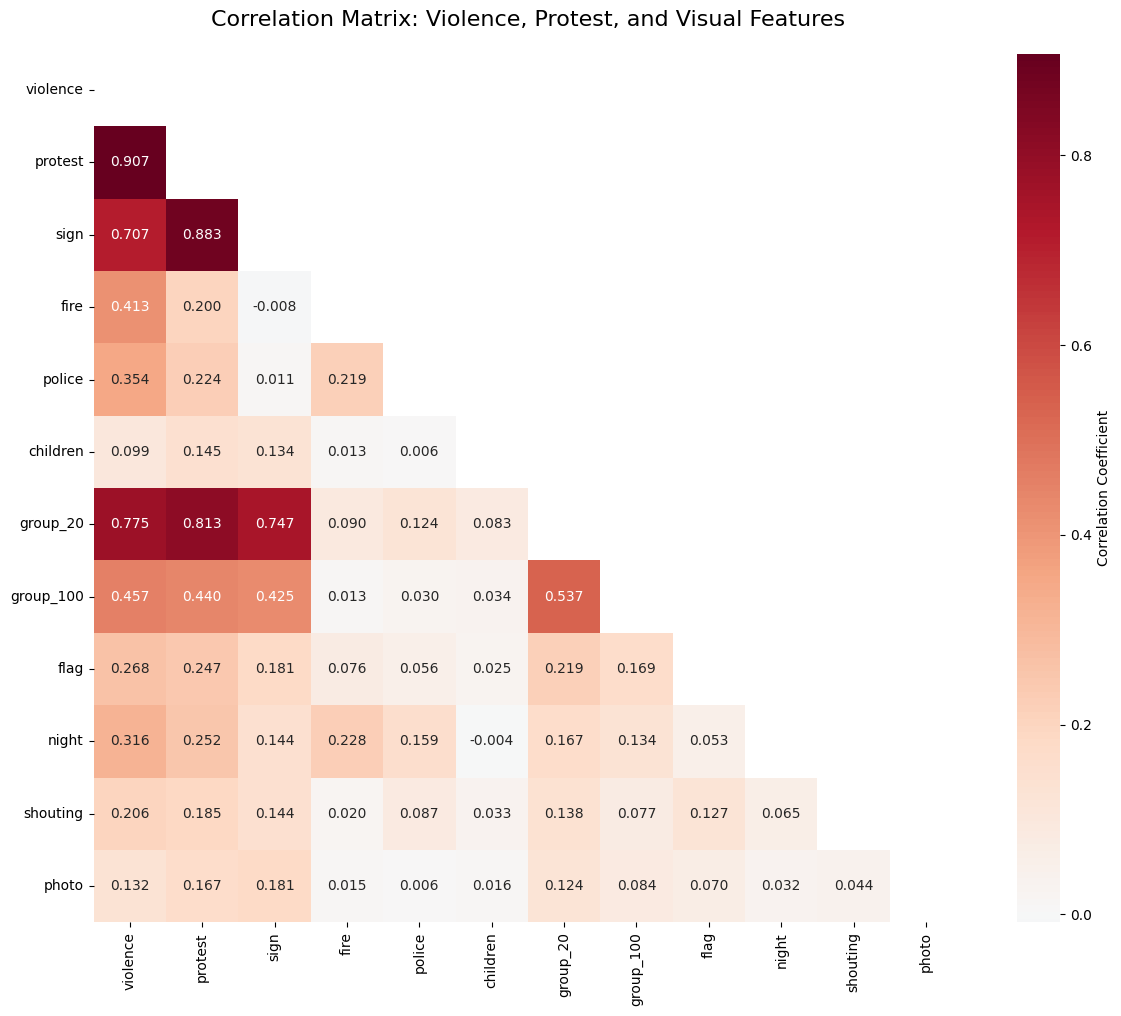


Correlation with violence (sorted by absolute value):
protest     : +0.907 (Strong positive)
group_20    : +0.775 (Strong positive)
sign        : +0.707 (Strong positive)
group_100   : +0.457 (Strong positive)
fire        : +0.413 (Strong positive)
police      : +0.354 (Strong positive)
night       : +0.316 (Strong positive)
flag        : +0.268 (Moderate positive)
shouting    : +0.206 (Moderate positive)
photo       : +0.132 (Moderate positive)
children    : +0.099 (Weak positive)


In [ ]:
# correlation analysis
create_correlation_analysis(annot_train)

In [13]:
# filter for samples with valid violence scores
valid_violence_mask = ~np.isnan(train_violence)
filtered_train_images = train_images[valid_violence_mask]
filtered_train_labels = train_labels[valid_violence_mask]
filtered_train_attributes = train_attributes[valid_violence_mask]
filtered_train_violence = train_violence[valid_violence_mask]

print(f"Original samples: {len(train_images)}")
print(f"Valid violence samples: {len(filtered_train_images)}")
print(f"Filtered out: {len(train_images) - len(filtered_train_images)} samples")

# split
X_train_unified, X_val_unified, y_protest_train, y_protest_val, y_attr_train, y_attr_val, y_violence_train, y_violence_val = train_test_split(
    filtered_train_images, filtered_train_labels, filtered_train_attributes, filtered_train_violence,
    test_size=0.2, random_state=42, stratify=filtered_train_labels
)

# create unified datasets
transform = get_transforms()
train_dataset_unified = UnifiedMultiTaskDataset(X_train_unified, y_protest_train, y_attr_train, y_violence_train, transform=transform)
val_dataset_unified = UnifiedMultiTaskDataset(X_val_unified, y_protest_val, y_attr_val, y_violence_val, transform=transform)

# filter test data for valid violence scores
test_valid_violence_mask = ~np.isnan(test_violence)
test_images_filtered = test_images[test_valid_violence_mask]
test_labels_filtered = test_labels[test_valid_violence_mask]
test_attributes_filtered = test_attributes[test_valid_violence_mask]
test_violence_filtered = test_violence[test_valid_violence_mask]

test_dataset_unified = UnifiedMultiTaskDataset(test_images_filtered, test_labels_filtered, test_attributes_filtered, test_violence_filtered, transform=transform)

# define data loaders
batch_size = 16
train_loader_unified = torch.utils.data.DataLoader(train_dataset_unified, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_unified = torch.utils.data.DataLoader(val_dataset_unified, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_unified = torch.utils.data.DataLoader(test_dataset_unified, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nTraining: {len(train_dataset_unified)} samples")
print(f"Validation: {len(val_dataset_unified)} samples") 
print(f"Test: {len(test_dataset_unified)} samples")
print(f"Batch size: {batch_size}")

# Loss functions and optimizers for each task
protest_criterion = nn.BCELoss()  # binary
attributes_criterion = nn.BCELoss()  # binary
violence_criterion = nn.MSELoss()  # regression
optimizer_unified = optim.Adam(unified_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_unified = optim.lr_scheduler.ReduceLROnPlateau(optimizer_unified, mode='min', factor=0.5, patience=3)

# loss weights (first experiment)
protest_weight = 1.0
attributes_weight = 0.5  # lower weight since we have 10 attributes
violence_weight = 1.0

Original samples: 32611
Valid violence samples: 32611
Filtered out: 0 samples

Training: 26088 samples
Validation: 6523 samples
Test: 8153 samples
Batch size: 16


In [ ]:
# train the model
unified_history = train_unified_model(
    model=unified_model,
    train_loader=train_loader_unified,
    val_loader=val_loader_unified,
    optimizer=optimizer_unified,
    scheduler=scheduler_unified,
    device=device,
    protest_criterion=protest_criterion,
    attributes_criterion=attributes_criterion,
    violence_criterion=violence_criterion,
    protest_weight=protest_weight,
    attributes_weight=attributes_weight,
    violence_weight=violence_weight,
    num_epochs=10
)

print(f"Protest accuracy: {unified_history['val_protest_acc'][-1]:.4f}")
print(f"Attributes accuracy: {unified_history['val_attributes_acc'][-1]:.4f}")
print(f"Violence MSE: {unified_history['val_violence_mse'][-1]:.6f}")
print(f"Total validation loss: {unified_history['val_loss'][-1]:.4f}")


Epoch 1/10


Training:   0%|          | 0/1631 [00:00<?, ?it/s]

Validation: 100%|██████████| 408/408 [00:30<00:00, 13.23it/s]



Loss - Train: 0.1859, Val: 0.4346
Protest Acc - Train: 0.9477, Val: 0.8731
Attributes Acc - Train: 0.9656, Val: 0.9539
Violence MSE - Train: 0.0080, Val: 0.0211
Saved new best model (Val Loss: 0.4346)

Epoch 2/10


Validation: 100%|██████████| 408/408 [00:32<00:00, 12.55it/s]



Loss - Train: 0.1476, Val: 0.4178
Protest Acc - Train: 0.9611, Val: 0.8809
Attributes Acc - Train: 0.9675, Val: 0.9565
Violence MSE - Train: 0.0061, Val: 0.0167
Saved new best model (Val Loss: 0.4178)

Epoch 3/10


Validation: 100%|██████████| 408/408 [00:36<00:00, 11.06it/s]


Loss - Train: 0.1249, Val: 0.4257
Protest Acc - Train: 0.9698, Val: 0.8862
Attributes Acc - Train: 0.9687, Val: 0.9569
Violence MSE - Train: 0.0053, Val: 0.0159

Epoch 4/10


Validation: 100%|██████████| 408/408 [00:37<00:00, 10.93it/s]


Loss - Train: 0.1097, Val: 0.4366
Protest Acc - Train: 0.9754, Val: 0.8810
Attributes Acc - Train: 0.9700, Val: 0.9557
Violence MSE - Train: 0.0046, Val: 0.0169

Epoch 5/10


Validation: 100%|██████████| 408/408 [00:31<00:00, 12.80it/s]


Loss - Train: 0.0751, Val: 0.4878
Protest Acc - Train: 0.9873, Val: 0.8912
Attributes Acc - Train: 0.9721, Val: 0.9589
Violence MSE - Train: 0.0034, Val: 0.0156

Epoch 6/10


Validation: 100%|██████████| 408/408 [00:36<00:00, 11.26it/s]


Loss - Train: 0.0582, Val: 0.5365
Protest Acc - Train: 0.9923, Val: 0.8927
Attributes Acc - Train: 0.9732, Val: 0.9593
Violence MSE - Train: 0.0025, Val: 0.0163

Epoch 7/10


Validation: 100%|██████████| 408/408 [00:31<00:00, 12.78it/s]

Loss - Train: 0.0556, Val: 0.5549
Protest Acc - Train: 0.9928, Val: 0.8899
Attributes Acc - Train: 0.9735, Val: 0.9577
Violence MSE - Train: 0.0024, Val: 0.0163
Early stopping triggered after 7 epochs
Protest accuracy: 0.8899
Attributes accuracy: 0.9577
Violence MSE: 0.016304
Total validation loss: 0.5549


In [34]:
# load best model
unified_model.load_state_dict(torch.load('results/best_unified_model.pt'))
unified_model.eval()

# evaluate
def evaluate_unified_model(model, test_loader):
    """Comprehensive evaluation of the unified model with optimizations."""
    all_protest_preds = []
    all_protest_labels = []
    all_attributes_preds = []
    all_attributes_labels = []
    all_violence_preds = []
    all_violence_labels = []
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, protest_labels, attribute_labels, violence_labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            protest_labels = protest_labels.to(device)
            attribute_labels = attribute_labels.to(device)
            violence_labels = violence_labels.to(device)
            
            # Forward pass
            protest_out, attributes_out, violence_out = model(inputs)
            
            # Reshape tensors for loss compatibility
            protest_out = protest_out.view(-1)  # Shape [batch_size]
            violence_out = violence_out.view(-1)  # Shape [batch_size]
            
            # Total loss calculation
            loss_protest = protest_criterion(protest_out, protest_labels.float())
            loss_attributes = attributes_criterion(attributes_out, attribute_labels)
            loss_violence = violence_criterion(violence_out, violence_labels.float())
            
            total_loss += (protest_weight * loss_protest + 
                          attributes_weight * loss_attributes + 
                          violence_weight * loss_violence).item()
            
            # Batch-wise storage
            all_protest_preds.append(protest_out.cpu().numpy())
            all_protest_labels.append(protest_labels.cpu().numpy())
            all_attributes_preds.append(attributes_out.cpu().numpy())
            all_attributes_labels.append(attribute_labels.cpu().numpy())
            all_violence_preds.append(violence_out.cpu().numpy())
            all_violence_labels.append(violence_labels.cpu().numpy())
    
    # Concatenate batches
    all_protest_preds = np.concatenate(all_protest_preds).flatten()
    all_protest_labels = np.concatenate(all_protest_labels).flatten()
    all_attributes_preds = np.concatenate(all_attributes_preds)
    all_attributes_labels = np.concatenate(all_attributes_labels)
    all_violence_preds = np.concatenate(all_violence_preds).flatten()
    all_violence_labels = np.concatenate(all_violence_labels).flatten()
    
    # Protest metrics
    protest_pred_binary = (all_protest_preds > 0.5).astype(int)
    protest_accuracy = accuracy_score(all_protest_labels, protest_pred_binary)
    protest_precision = precision_score(all_protest_labels, protest_pred_binary)
    protest_recall = recall_score(all_protest_labels, protest_pred_binary)
    protest_f1 = f1_score(all_protest_labels, protest_pred_binary)
    
    # Attributes metrics
    attributes_pred_binary = (all_attributes_preds > 0.5).astype(int)
    attributes_accuracy = accuracy_score(all_attributes_labels.flatten(), attributes_pred_binary.flatten())
    
    # Dynamic attribute count handling
    attr_accuracies = []
    for i in range(all_attributes_labels.shape[1]):
        attr_acc = accuracy_score(all_attributes_labels[:, i], attributes_pred_binary[:, i])
        attr_accuracies.append(attr_acc)
    
    # Violence metrics
    violence_mse = np.mean((all_violence_preds - all_violence_labels) ** 2)
    violence_rmse = np.sqrt(violence_mse)
    violence_r2 = r2_score(all_violence_labels, all_violence_preds)
    
    avg_loss = total_loss / len(test_loader)
    
    return {
        'total_loss': avg_loss,
        'protest': {
            'accuracy': protest_accuracy,
            'precision': protest_precision,
            'recall': protest_recall,
            'f1': protest_f1,
            'predictions': all_protest_preds,
            'labels': all_protest_labels
        },
        'attributes': {
            'overall_accuracy': attributes_accuracy,
            'per_attribute_accuracy': attr_accuracies,
            'predictions': all_attributes_preds,
            'labels': all_attributes_labels
        },
        'violence': {
            'mse': violence_mse,
            'rmse': violence_rmse,
            'r2': violence_r2,
            'predictions': all_violence_preds,
            'labels': all_violence_labels
        }
    }

unified_results = evaluate_unified_model(unified_model, test_loader_unified)

print(f"Overall Loss: {unified_results['total_loss']:.4f}")

print(f"\nProtest detection:")
print(f"Accuracy:  {unified_results['protest']['accuracy']:.4f}")
print(f"Precision: {unified_results['protest']['precision']:.4f}")
print(f"Recall:    {unified_results['protest']['recall']:.4f}")
print(f"F1-Score:  {unified_results['protest']['f1']:.4f}")

print(f"\nVisual attributes:")
print(f"Overall Accuracy: {unified_results['attributes']['overall_accuracy']:.4f}")
print(f"Per-Attribute Accuracy:")
for i, attr in enumerate(unified_model.attribute_names):
    acc = unified_results['attributes']['per_attribute_accuracy'][i]
    print(f"{attr:>12}: {acc:.4f}")

print(f"\nViolence prediction:")
print(f"MSE:  {unified_results['violence']['mse']:.4f}")
print(f"RMSE: {unified_results['violence']['rmse']:.4f}")
print(f"R²:   {unified_results['violence']['r2']:.4f}")

Evaluating: 100%|██████████| 510/510 [00:26<00:00, 19.18it/s]

Overall Loss: 0.4246

Protest detection:
Accuracy:  0.8765
Precision: 0.7797
Recall:    0.7947
F1-Score:  0.7871

Visual attributes:
Overall Accuracy: 0.9573
Per-Attribute Accuracy:
        sign: 0.8863
       photo: 0.9915
        fire: 0.9845
      police: 0.9800
    children: 0.9909
    group_20: 0.8700
   group_100: 0.9290
        flag: 0.9765
       night: 0.9773
    shouting: 0.9866

Violence prediction:
MSE:  0.0177
RMSE: 0.1331
R²:   0.4818


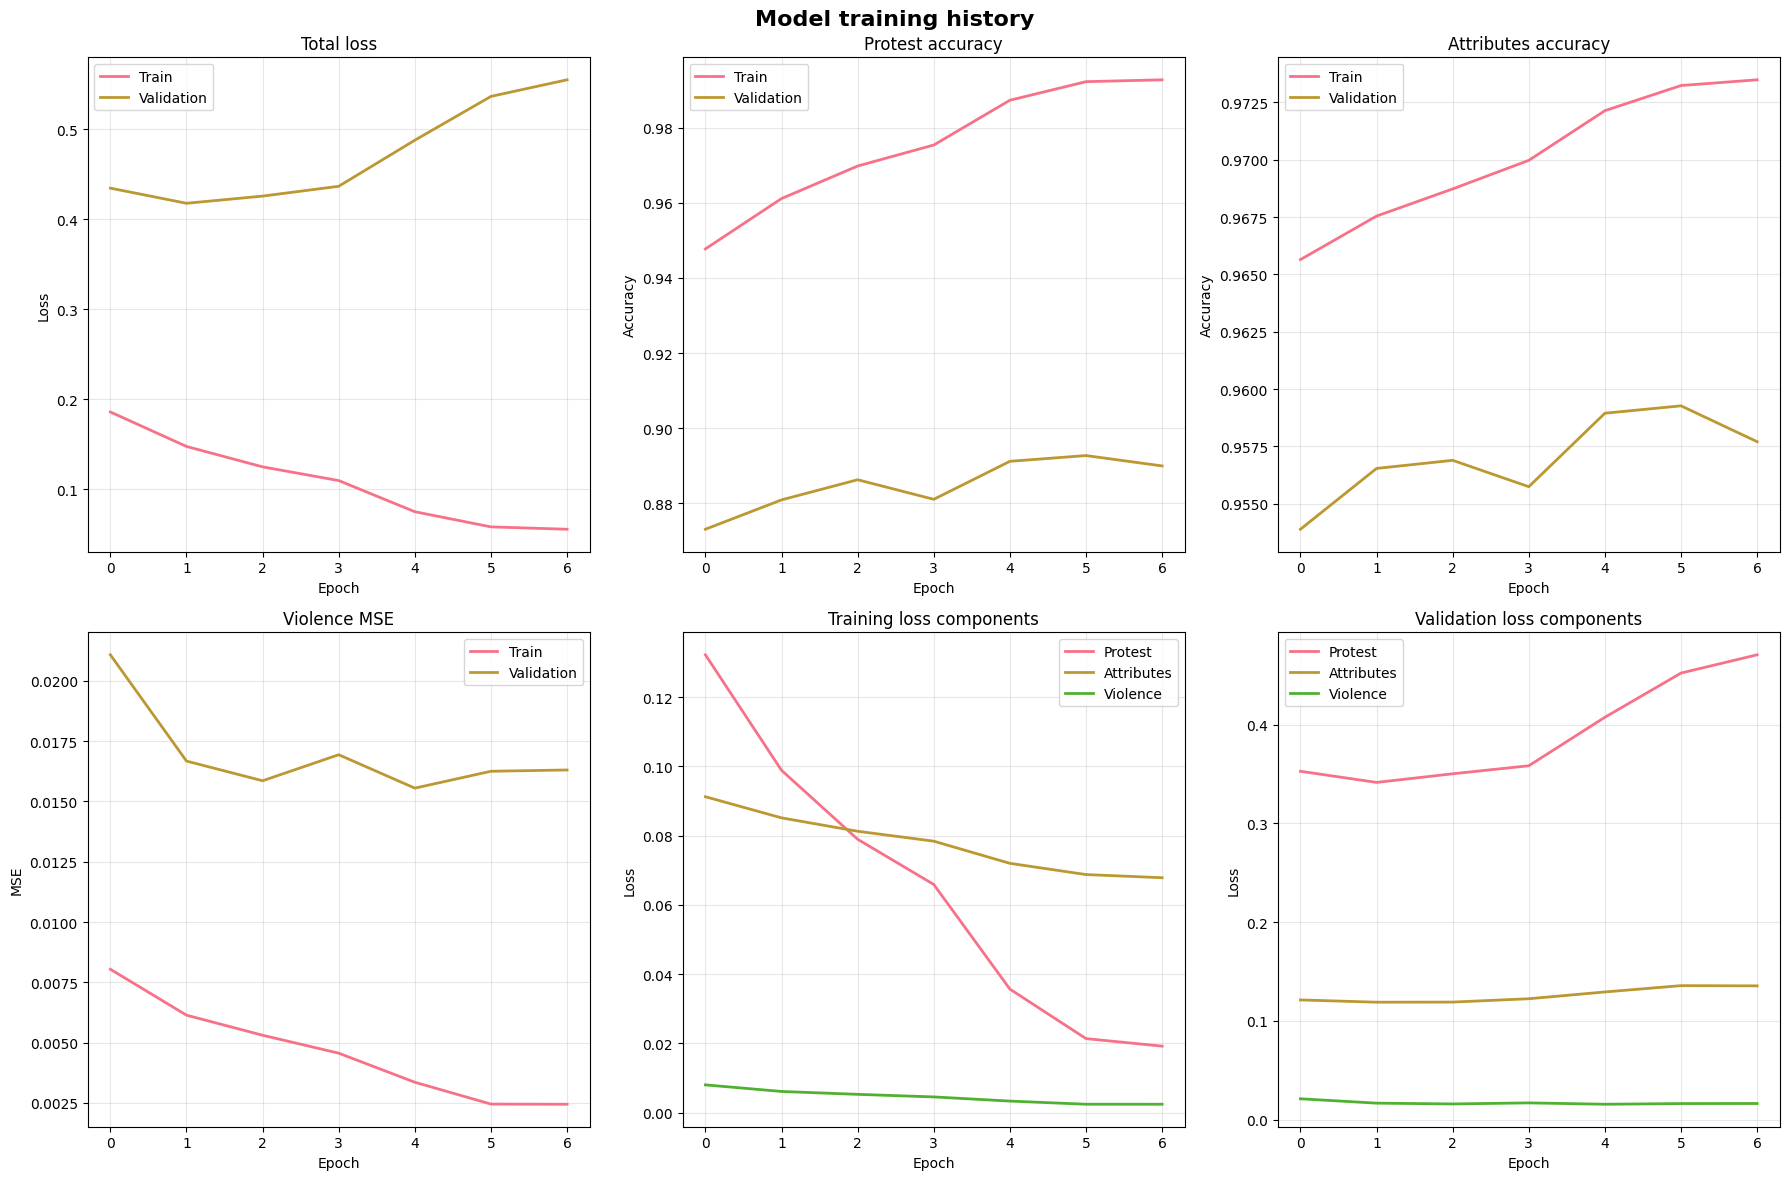

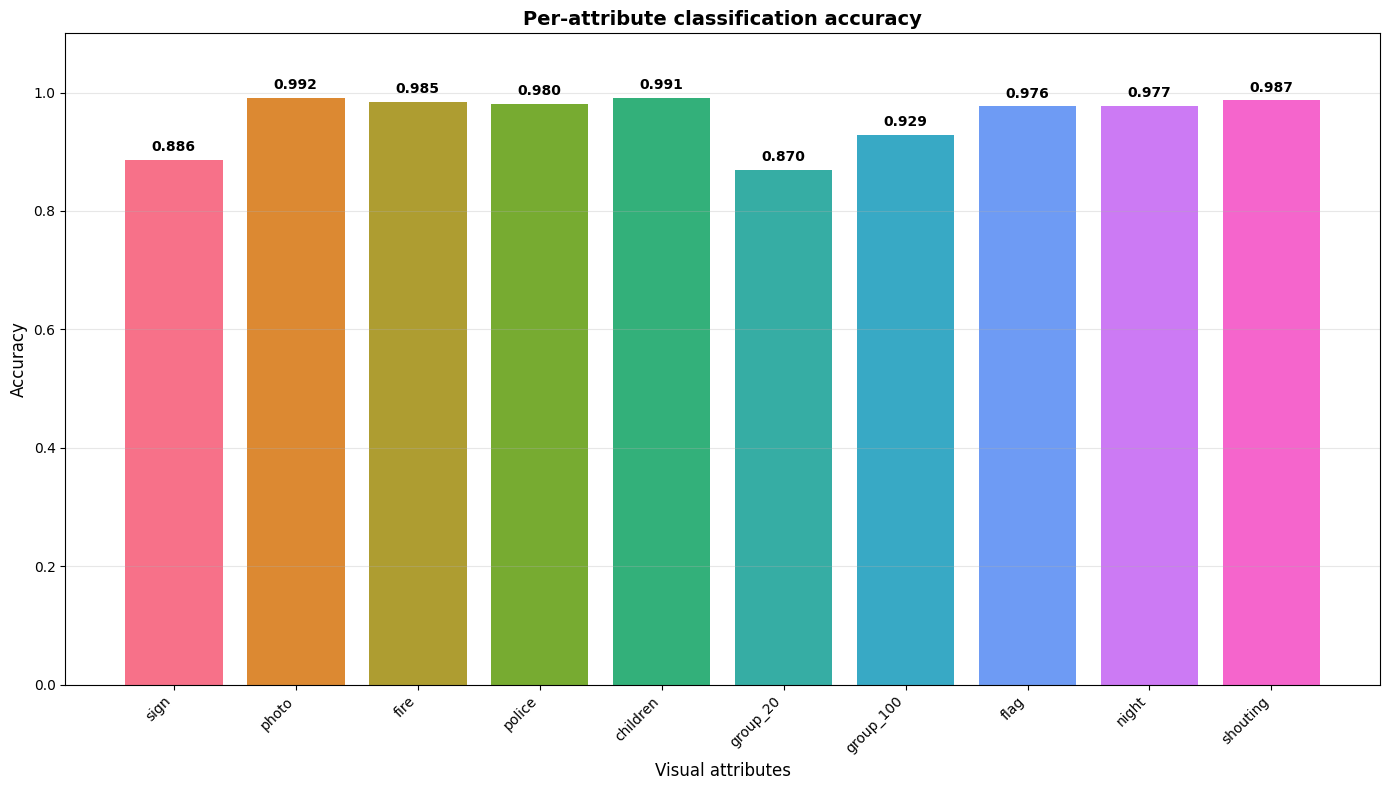

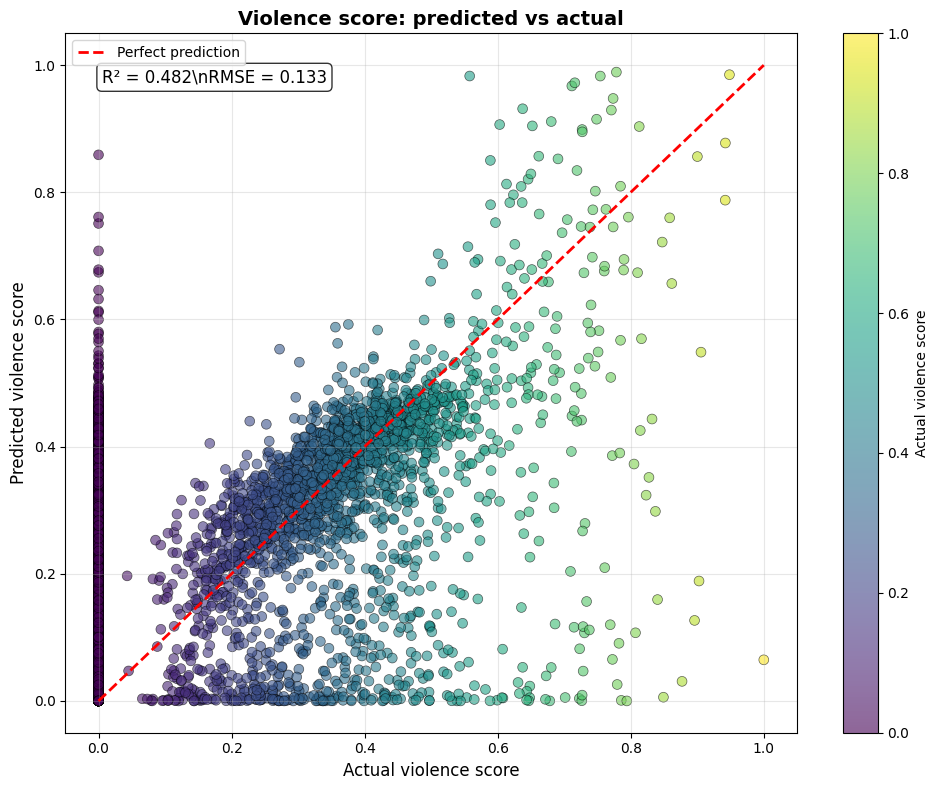

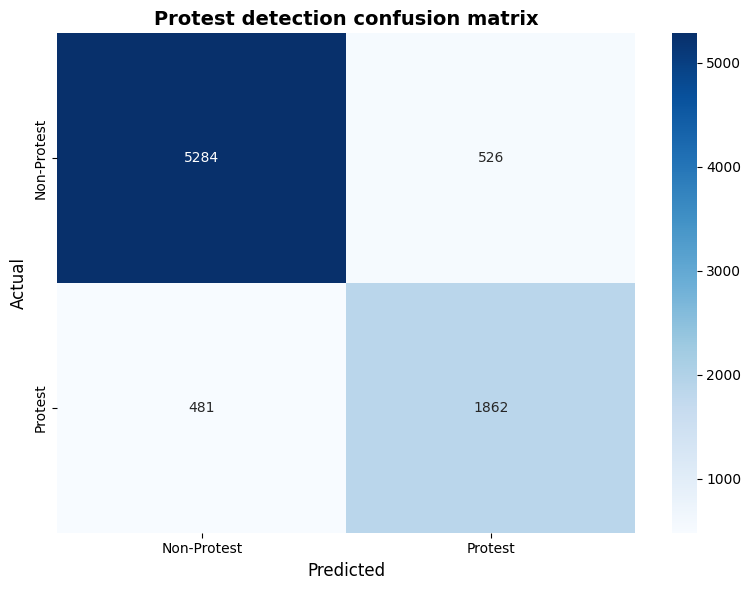

In [35]:
# plot some visualizations
plt.style.use('default')
sns.set_palette("husl")

# 1. training history
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model training history', fontsize=16, fontweight='bold')

# losses
axes[0, 0].plot(unified_history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(unified_history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Total loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(unified_history['train_protest_acc'], label='Train', linewidth=2)
axes[0, 1].plot(unified_history['val_protest_acc'], label='Validation', linewidth=2)
axes[0, 1].set_title('Protest accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(unified_history['train_attributes_acc'], label='Train', linewidth=2)
axes[0, 2].plot(unified_history['val_attributes_acc'], label='Validation', linewidth=2)
axes[0, 2].set_title('Attributes accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(unified_history['train_violence_mse'], label='Train', linewidth=2)
axes[1, 0].plot(unified_history['val_violence_mse'], label='Validation', linewidth=2)
axes[1, 0].set_title('Violence MSE')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# individual loss components
axes[1, 1].plot(unified_history['train_protest_loss'], label='Protest', linewidth=2)
axes[1, 1].plot(unified_history['train_attributes_loss'], label='Attributes', linewidth=2)
axes[1, 1].plot(unified_history['train_violence_loss'], label='Violence', linewidth=2)
axes[1, 1].set_title('Training loss components')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(unified_history['val_protest_loss'], label='Protest', linewidth=2)
axes[1, 2].plot(unified_history['val_attributes_loss'], label='Attributes', linewidth=2)
axes[1, 2].plot(unified_history['val_violence_loss'], label='Violence', linewidth=2)
axes[1, 2].set_title('Validation loss components')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/unified_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. per-attribute performance
fig, ax = plt.subplots(figsize=(14, 8))
attr_names = unified_model.attribute_names
attr_accs = unified_results['attributes']['per_attribute_accuracy']

bars = ax.bar(range(len(attr_names)), attr_accs, color=sns.color_palette("husl", len(attr_names)))
ax.set_xlabel('Visual attributes', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Per-attribute classification accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(attr_names)))
ax.set_xticklabels(attr_names, rotation=45, ha='right')

for i, (bar, acc) in enumerate(zip(bars, attr_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('results/unified_attributes_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. violence prediction scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
violence_preds = unified_results['violence']['predictions']
violence_labels = unified_results['violence']['labels']

scatter = ax.scatter(violence_labels, violence_preds, alpha=0.6, c=violence_labels, 
                    cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')

ax.set_xlabel('Actual violence score', fontsize=12)
ax.set_ylabel('Predicted violence score', fontsize=12)
ax.set_title('Violence score: predicted vs actual', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

r2 = unified_results['violence']['r2']
rmse = unified_results['violence']['rmse']
ax.text(0.05, 0.95, f'R² = {r2:.3f}\\nRMSE = {rmse:.3f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.colorbar(scatter, label='Actual violence score')
plt.tight_layout()
plt.savefig('results/unified_violence_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. confusion matrix

protest_pred_binary = (unified_results['protest']['predictions'] > 0.5).astype(int)
cm = confusion_matrix(unified_results['protest']['labels'], protest_pred_binary)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Non-Protest', 'Protest'],
           yticklabels=['Non-Protest', 'Protest'],
           ax=ax)
ax.set_title('Protest detection confusion matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.savefig('results/unified_protest_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

The model shows signs of overfitting:
- Training accuracy reaches nearly 100% while validation accuracy plateaus around 89%
- Training loss continues to decrease while validation loss starts increasing after epoch 2.

Things we can try to address it:
- Increase regularization (try higher dropout rates or L2 regularization)
- Implement data augmentation (rotations, flips, color change)
- Reduce model complexity or add more dropout layers.

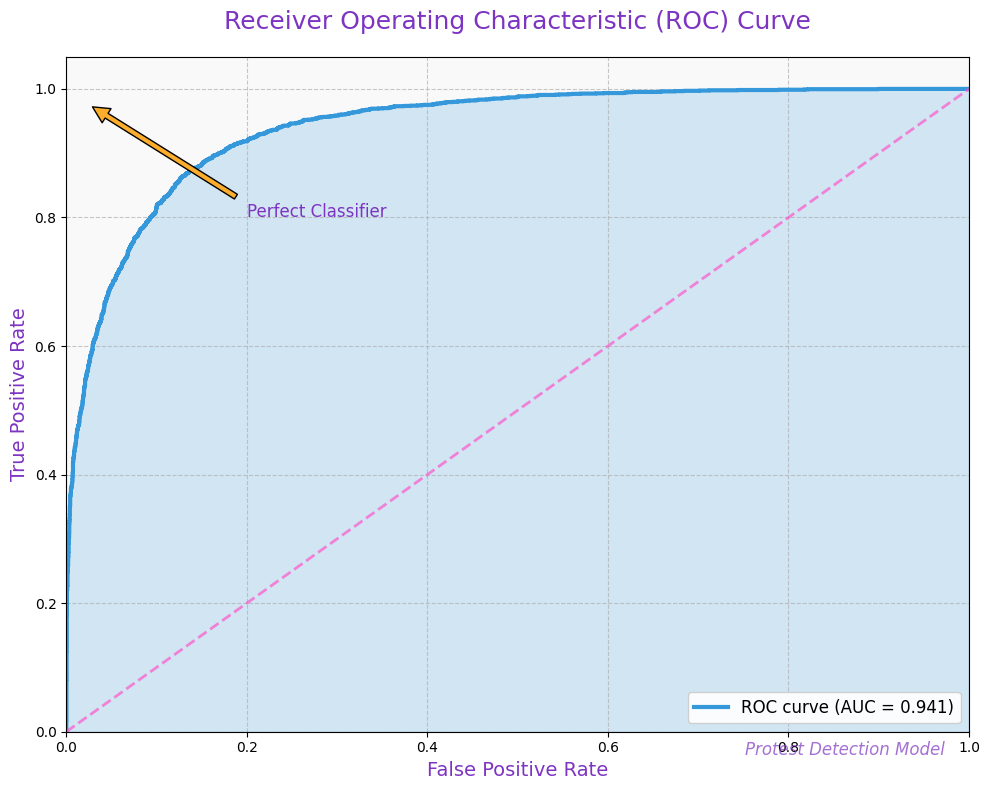

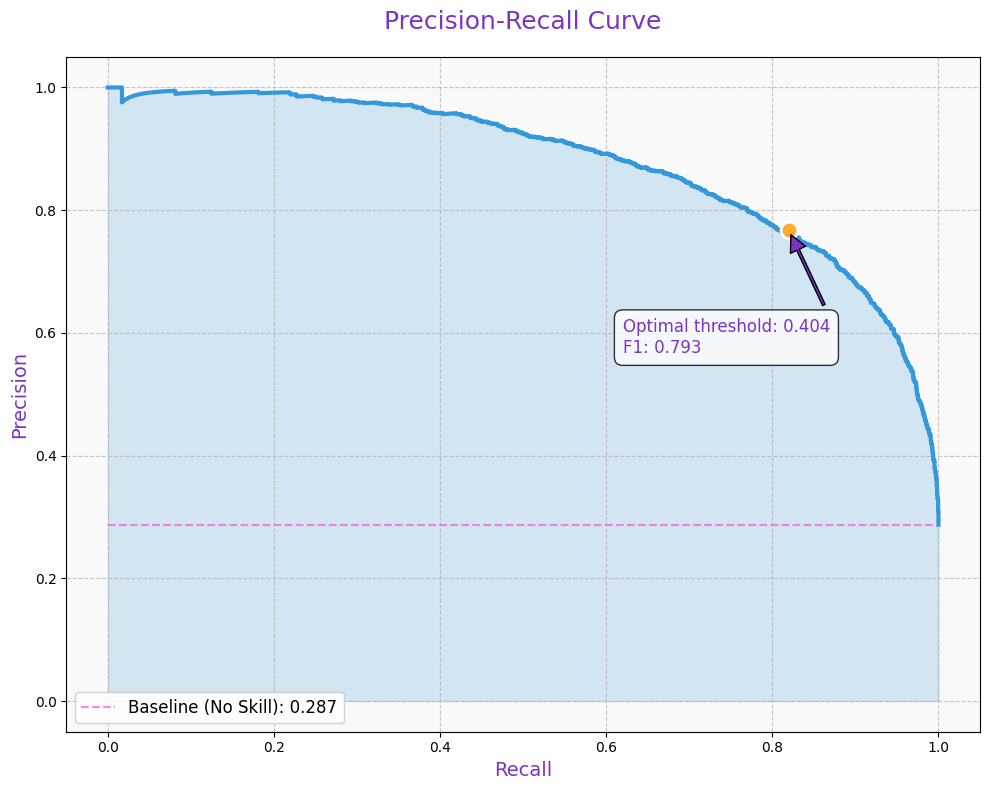

Optimal classification threshold: 0.4043


In [36]:
# 2. Plot stylish ROC curve
# Extract the predictions and labels from unified_results
all_protest_labels = unified_results['protest']['labels']
all_protest_preds = unified_results['protest']['predictions']

plot_stylish_roc_curve(all_protest_labels, all_protest_preds)
optimal_threshold = plot_stylish_pr_curve(all_protest_labels, all_protest_preds)
print(f"Optimal classification threshold: {optimal_threshold:.4f}")

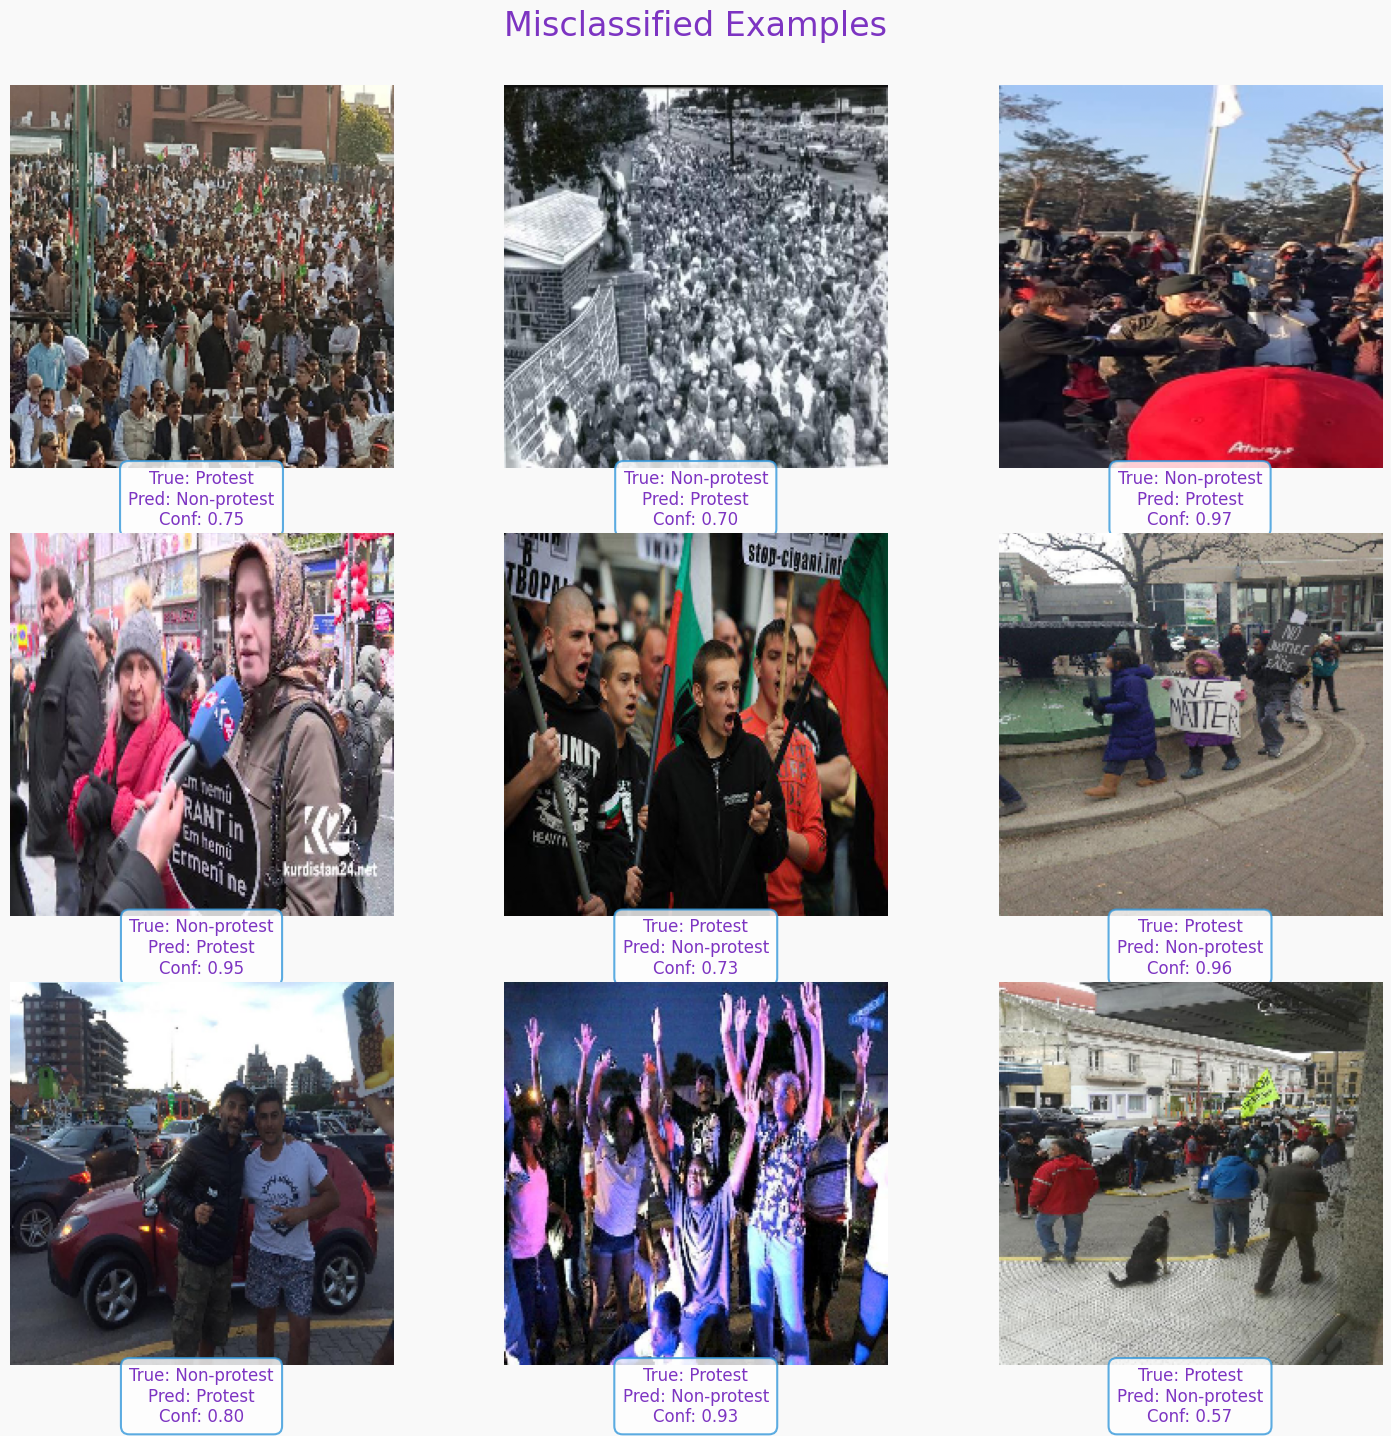

In [40]:
# misclassification examples
all_preds = (all_protest_preds > 0.5).astype(int)
test_image_paths_filtered = [test_image_paths[i] for i in range(len(test_image_paths)) if test_valid_violence_mask[i]]

plot_stylish_misclassifications(
    test_image_paths_filtered, all_protest_labels, all_preds, all_protest_preds,
    save_path=r'results\misclassifications.png'
)

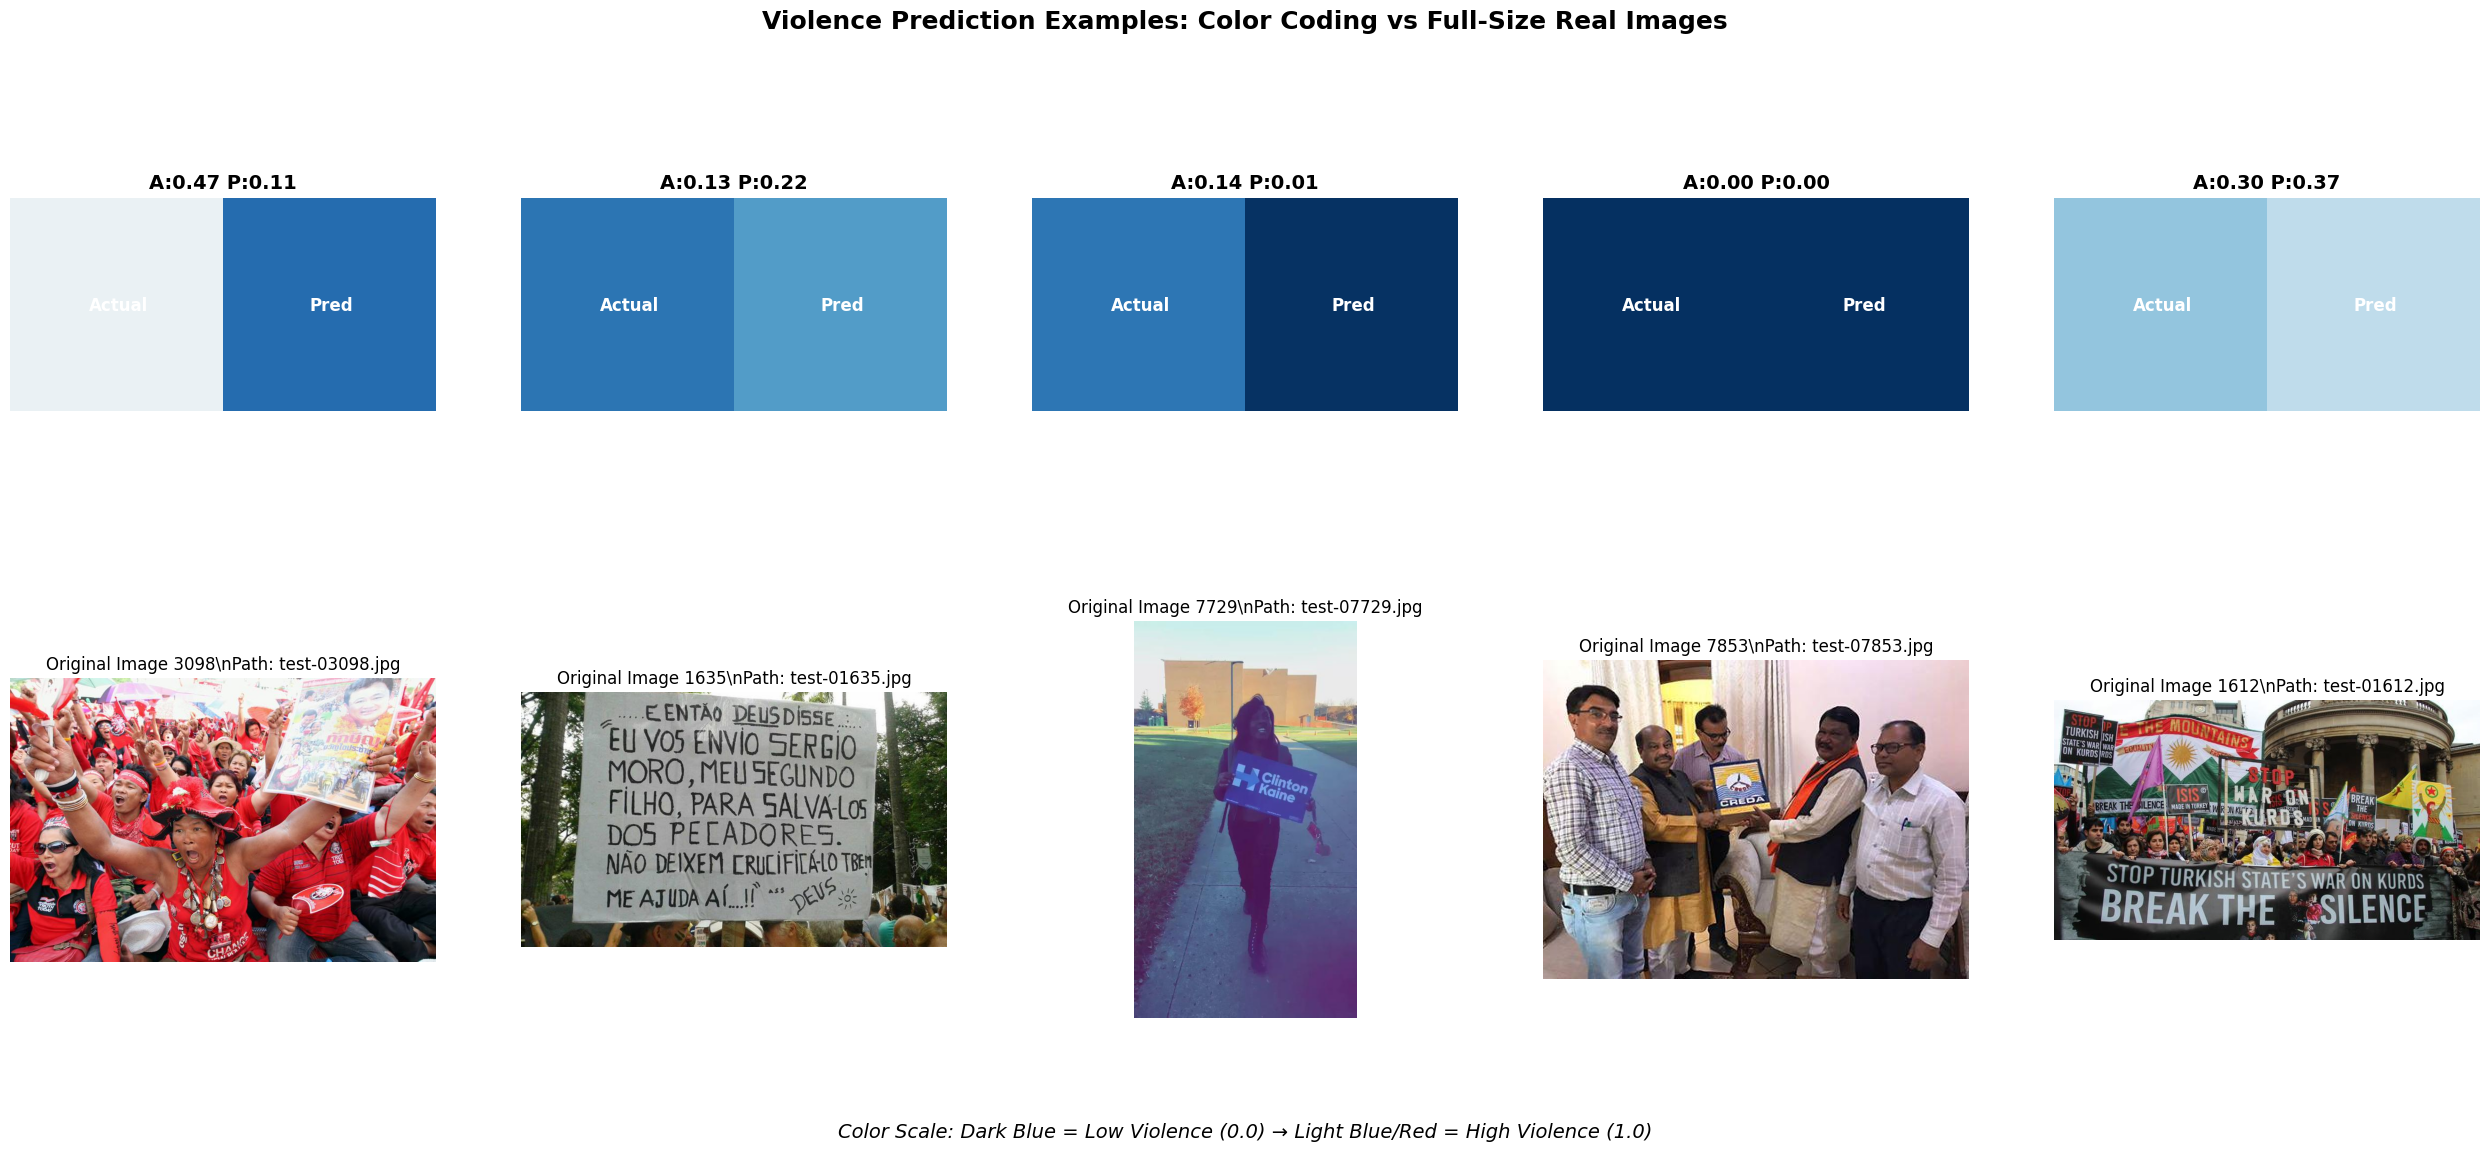

In [49]:
# get violence data
all_violence_labels = unified_results['violence']['labels']
all_violence_preds = unified_results['violence']['predictions']

# some random examples from test set
test_indices = np.where(test_valid_violence_mask)[0]
if len(test_indices) > 0:
    sample_indices = np.random.choice(len(all_violence_labels), min(5, len(all_violence_labels)), replace=False)
    
    fig, axes = plt.subplots(2, min(5, len(sample_indices)), figsize=(25, 12))
    if len(sample_indices) == 1:
        axes = axes.reshape(2, 1)
    
    for i, idx in enumerate(sample_indices[:5]):
        if i < axes.shape[1]:
            actual_color = plt.cm.RdBu_r(all_violence_labels[idx])
            pred_color = plt.cm.RdBu_r(all_violence_preds[idx])
            
            # color blocks
            color_block = np.ones((50, 100, 3))
            color_block[:, :50] = actual_color[:3]  # left half - actual
            color_block[:, 50:] = pred_color[:3]    # right half - predicted
            
            axes[0, i].imshow(color_block)
            axes[0, i].set_title(f'A:{all_violence_labels[idx]:.2f} P:{all_violence_preds[idx]:.2f}', 
                                fontsize=14, fontweight='bold')
            axes[0, i].axis('off')
            
            axes[0, i].text(25, 25, 'Actual', ha='center', va='center', 
                           fontsize=12, fontweight='bold', color='white')
            axes[0, i].text(75, 25, 'Pred', ha='center', va='center', 
                           fontsize=12, fontweight='bold', color='white')
            
            # original full-size images
            try:
                img_path = test_image_paths_filtered[idx]
                original_img = Image.open(img_path)
                if original_img.mode != 'RGB':
                    original_img = original_img.convert('RGB')
                
                axes[1, i].imshow(original_img)
                axes[1, i].set_title(f'Original Image {idx}\\nPath: {os.path.basename(img_path)}', 
                                   fontsize=12, wrap=True)
                axes[1, i].axis('off')
                
            except Exception as e:
                # fallback: show processed image if original can't be loaded
                print(f"Could not load original image {img_path}: {e}")
                img_array = test_images_filtered[idx]
                
                # denormalize image for display
                if img_array.max() <= 1.0:
                    display_img = (img_array * 255).astype(np.uint8)
                else:
                    display_img = img_array.astype(np.uint8)
                
                if display_img.shape[0] == 3:
                    display_img = np.transpose(display_img, (1, 2, 0))
                
                axes[1, i].imshow(display_img)
                axes[1, i].set_title(f'Processed Image {idx}', fontsize=12)
                axes[1, i].axis('off')
    
    fig.suptitle('Violence Prediction Examples: Color Coding vs Full-Size Real Images', 
                 fontsize=18, fontweight='bold', y=0.96)
    
    fig.text(0.5, 0.02, 'Color Scale: Dark Blue = Low Violence (0.0) → Light Blue/Red = High Violence (1.0)', 
             ha='center', fontsize=14, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.12, hspace=0.3, wspace=0.2)
    
    plt.savefig(r'results\violence_prediction_examples_with_images.png', dpi=300, bbox_inches='tight')
    plt.show()